In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohammedabdeldayem/the-fake-or-real-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/the-fake-or-real-dataset


In [10]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Reshape

# Define dataset path (automatically mounted by Kaggle)
DATASET_PATH = "/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training"


In [3]:
def extract_features(file_path, sr=22050, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr)

    # Compute Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize and combine features
    features = np.vstack([mel_spec[:40], mfcc])
    
    return features.T  # Transpose for shape (Time, Features)

# Load dataset (Real and Fake samples)
def load_dataset(directory):
    X, y = [], []
    for label in ["real", "fake"]:
        path = os.path.join(directory, label)
        for file in os.listdir(path):
            if file.endswith(".wav"):
                features = extract_features(os.path.join(path, file))
                X.append(features)
                y.append(label)
    
    return np.array(X), np.array(y)

# Load the dataset
X, y = load_dataset(DATASET_PATH)


In [7]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_flat = np.concatenate([x.reshape(-1, x.shape[-1]) for x in X])
scaler.fit(X_flat)
X = np.array([scaler.transform(x) for x in X])

max_timesteps = max(x.shape[0] for x in X)  # Find max time dimension
X_padded = np.array([np.pad(x, ((0, max_timesteps - x.shape[0]), (0, 0)), mode='constant') for x in X])

# Reshape for CNN-LSTM (samples, time steps, features, 1)
X_padded = X_padded.reshape(X_padded.shape[0], X_padded.shape[1], X_padded.shape[2], 1)



# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Convert labels to categorical format
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, TimeDistributed, Reshape, BatchNormalization, Input

# Define Input Layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))  

# CNN Feature Extractor
x = TimeDistributed(Conv1D(32,kernel_size=3,activation='relu', padding='same'))(input_layer)
x = TimeDistributed(BatchNormalization())(x)



x = TimeDistributed(Conv1D(64,kernel_size=3,activation='relu', padding='same'))(x)
x = TimeDistributed(BatchNormalization())(x)



x = TimeDistributed(Flatten())(x)

# Reshape before LSTM
x = Reshape((X_train.shape[1], -1))(x)  #  Ensures correct shape

# LSTM for Sequence Modeling
x = LSTM(64, return_sequences=False)(x)

# Fully Connected Layers
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(2, activation="softmax")(x)  # Output: Real or Fake

# Define Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train Model
history = model.fit(X_train, y_train, epochs=30)


Epoch 1/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 130s 237ms/step - accuracy: 0.8424 - loss: 0.3456
Epoch 2/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9675 - loss: 0.0915
Epoch 3/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.9795 - loss: 0.0608
Epoch 4/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9683 - loss: 0.0853
Epoch 5/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 237ms/step - accuracy: 0.9727 - loss: 0.0692
Epoch 6/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9772 - loss: 0.0613
Epoch 7/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 84s 239ms/step - accuracy: 0.9870 - loss: 0.0371
Epoch 8/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.9812 - loss: 0.0486
Epoch 9/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9914 - loss: 0.0271
Epoch 10/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 238ms/step - accuracy: 0.9939 - loss: 0.0159
Epoch 11/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 239ms/step - accuracy: 0.9885 - loss: 0.0285
Epoch 12/30
349/34

In [12]:
acc=model.evaluate(X_test,y_test,verbose=0)[1]
print(acc)

0.9924784898757935


In [14]:
model.save("audio_classification_model.h5")

In [33]:
def predict_audio(file_path):
    features = extract_features(file_path)  # Extracted shape: (timesteps, features)

    # Ensure features match StandardScaler input shape
    if features.shape[1] != num_features:
        raise ValueError(f"Feature shape mismatch! Expected {num_features}, got {features.shape[1]}.")

    # Normalize using fitted scaler
    features = scaler.transform(features)

    # Pad sequence to match training shape
    features = np.pad(features, ((0, max_timesteps - features.shape[0]), (0, 0)), mode='constant')

    # Reshape for CNN-LSTM model input
    features = features.reshape(1, features.shape[0], features.shape[1], 1)  # (1, timesteps, features, 1)

    # Predict using trained model
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction, axis=1)[0]

    return "Real" if predicted_label == 0 else "Fake"


# ==============================
# ✅ Example Usage (Fixed)
# ==============================
audio_file="/kaggle/input/the-fake-or-real-dataset/for-rerec/for-rerecorded/testing/fake/recording13014.wav_norm_mono.wav"
result = predict_audio(audio_file)
print(f"Prediction: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction: Fake


In [ ]:
print(np.argmax(model.predict(X_test[:5]))) # Ensure this runs without error


In [34]:
# Evaluate Model on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_mat=classification_report(y_true, y_pred_classes)
print(conf_mat)


Test Accuracy: 99.25%
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1383
           1       1.00      0.99      0.99      1409

    accuracy                           0.99      2792
   macro avg       0.99      0.99      0.99      2792
weighted avg       0.99      0.99      0.99      2792



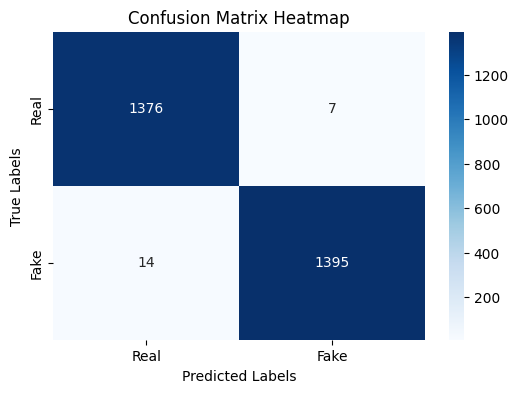

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred_classes)


class_labels = ["Real", "Fake"]


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)


plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap")
plt.show()
